# Mid-Price LSTM-New

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam
from keras.layers import Input, Dense, LSTM, TimeDistributed, GRU, SimpleRNN
from keras.models import Model
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve, auc

2023-04-28 12:58:15.858891: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-28 12:58:16.992642: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


## Data Pre-Processing

### Import the data

In [2]:
file_1='/tmp/pycharm_project_983/Data Science Mini-project/Project/LOBs_Benchmark/1Benchmark_Set01_2024-01-02LOBs.csv'

### For the Single File

1. Rename the columns and remove the first row

In [3]:
data_original=pd.read_csv(file_1, header=[0,1,2])
data_original=data_original[1:]
data_original.rename(columns={'Unnamed: 0_level_0':'Time','Unnamed: 0_level_1': '','Unnamed: 0_level_2': '','Unnamed: 3_level_1':'','Unnamed: 3_level_2':''},inplace=True),
data_original.rename(columns={'Unnamed: 0_level_0':'Time','Unnamed: 0_level_1': '','Unnamed: 0_level_2': '','Unnamed: 3_level_1':'','Unnamed: 3_level_2':'','Unnamed: 2_level_2':'','Unnamed: 2_level_1':'','Unnamed: 4_level_2':'','Unnamed: 4_level_1':''},inplace=True),
data_original

/tmp/ipykernel_25984/615884661.py:1: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  data_original=pd.read_csv(file_1, header=[0,1,2])


Time             Encode Quoted_spread Mid_Price  \
                  Unnamed: 1_level_1                           
                  Unnamed: 1_level_2                           
1             0.0              Exch0           0.0       0.0   
2           0.093              Exch0         239.0     119.5   
3            1.24              Exch0         239.0     119.5   
4           2.542              Exch0         238.0     120.0   
5           2.666              Exch0         238.0     120.0   
...           ...                ...           ...       ...   
333592  30599.604              Exch0          12.0     271.0   
333593  30599.666              Exch0          12.0     271.0   
333594  30599.697              Exch0          12.0     271.0   
333595  30599.728              Exch0          12.0     271.0   
333596  30599.945              Exch0          12.0     271.0   

       Weighted_Mid_Price     Best_bid_price         bid_volume  \
                          Unnamed: 5_level_1 Unnamed: 6_level_1   
                          Unnamed: 5_level_2 Unnamed: 6_level_2   
1                     0.0                NaN                NaN   
2                     NaN                NaN                NaN   
3                     NaN                NaN                NaN   
4                   179.5                1.0                6.0   
5                   179.5                1.0                6.0   
...                   ...                ...                ...   
333592              274.0              265.0                6.0   
333593              274.0              265.0                6.0   
333594              274.0              265.0                6.0   
333595              274.0              265.0                6.0   
333596              274.0              265.0                6.0   

           Best_ask_price         ask_volume  \
       Unnamed: 7_level_1 Unnamed: 8_level_1   
       Unnamed: 7_level_2 Unnamed: 8_level_2   
1                     NaN                NaN   
2                   239.0                2.0   
3                   239.0                2.0   
4                   239.0                2.0   
5                   239.0                2.0   
...                   ...                ...   
333592              277.0                2.0   
333593              277.0                2.0   
333594              277.0                2.0   
333595              277.0                2.0   
333596              277.0                2.0   

                                                      bid  ... level13         \
                                       Unnamed: 9_level_1  ...     Ask          
                                       Unnamed: 9_level_2  ...   Price Volume   
1                                                      []  ...     NaN    NaN   
2                                                      []  ...     NaN    NaN   
3                                                      []  ...     NaN    NaN   
4                                                [[1, 6]]  ...     NaN    NaN   
5                                                [[1, 6]]  ...     NaN    NaN   
...                                                   ...  ...     ...    ...   
333592  [[265, 6], [260, 8], [257, 7], [89, 1], [73, 1...  ...     NaN    NaN   
333593  [[265, 6], [260, 8], [257, 7], [89, 1], [73, 1...  ...     NaN    NaN   
333594  [[265, 6], [260, 8], [257, 7], [89, 1], [73, 1...  ...     NaN    NaN   
333595  [[265, 6], [260, 8], [257, 7], [89, 1], [73, 1...  ...     NaN    NaN   
333596  [[265, 6], [260, 8], [257, 7], [89, 1], [73, 1...  ...     NaN    NaN   

       level14                     level15                      
           Bid          Ask            Bid          Ask         
         Price Volume Price Volume   Price Volume Price Volume  
1          NaN    NaN   NaN    NaN     NaN    NaN   NaN    NaN  
2          NaN    NaN   NaN    NaN     NaN    NaN   NaN    NaN  
3          NaN    NaN   NaN    NaN     NaN  

2. Only keep the columns:

In [4]:
data=data_original.loc[:,['Time','level1','level2','level3','level4','level5','Quoted_spread','Weighted_Mid_Price','Mid_Price']]

In [5]:
data.columns = data.columns.map('_'.join)
data.rename(columns={'Time__':'Time','Mid_Price__':'Mid_Price','Weighted_Mid_Price__':'Weighted_Mid_Price','Quoted_spread__':'Quoted_spread'},inplace=True)

3. Only keep the rows:

In [6]:
min_index=0
max_index=0
last_value = data['Time'].iloc[-1]
for index, row in data.iterrows():
    if pd.to_numeric(row['Time'])>3600:
        min_index=index
        break
for index, row in data.iterrows():
    if pd.to_numeric(row['Time'])>last_value-3600:
        max_index=index
        break

data=data[min_index:max_index]
data.head(10)

,Time,level1_Bid_Price,level1_Bid_Volume,level1_Ask_Price,level1_Ask_Volume,level2_Bid_Price,level2_Bid_Volume,level2_Ask_Price,level2_Ask_Volume,level3_Bid_Price,...,level4_Bid_Volume,level4_Ask_Price,level4_Ask_Volume,level5_Bid_Price,level5_Bid_Volume,level5_Ask_Price,level5_Ask_Volume,Quoted_spread,Weighted_Mid_Price,Mid_Price
39724,3600.247,258.0,12.0,262.0,2.0,257.0,6.0,263.0,4.0,256.0,...,9.0,346.0,3.0,11.0,3.0,596.0,2.0,4.0,261.428571,260.0
39725,3600.464,258.0,12.0,262.0,2.0,257.0,6.0,263.0,4.0,256.0,...,7.0,346.0,3.0,99.0,9.0,596.0,2.0,4.0,261.428571,260.0
39726,3600.588,259.0,2.0,262.0,2.0,258.0,12.0,263.0,4.0,257.0,...,2.0,346.0,3.0,249.0,7.0,596.0,2.0,3.0,260.500000,260.5
39727,3600.65,259.0,2.0,262.0,2.0,258.0,10.0,263.0,4.0,257.0,...,2.0,346.0,3.0,254.0,2.0,596.0,2.0,3.0,260.500000,260.5
39728,3600.743,260.0,1.0,262.0,2.0,259.0,2.0,263.0,4.0,258.0,...,6.0,346.0,3.0,256.0,2.0,596.0,2.0,2.0,260.666667,261.0
39729,3600.836,260.0,1.0,262.0,2.0,259.0,2.0,264.0,4.0,258.0,...,6.0,346.0,3.0,256.0,2.0,596.0,2.0,2.0,260.666667,261.0
39730,3600.929,260.0,1.0,262.0,2.0,259.0,2.0,264.0,4.0,258.0,...,6.0,346.0,3.0,254.0,4.0,596.0,2.0,2.0,260.666667,261.0
39731,3601.053,260.0,1.0,262.0,2.0,259.0,2.0,264.0,4.0,258.0,...,6.0,346.0,3.0,254.0,4.0,596.0,2.0,2.0,260.666667,261.0
39732,3601.115,260.0,1.0,262.0,2.0,259.0,2.0,264.0,4.0,258.0,...,6.0,346.0,3.0,254.0,4.0,596.0,2.0,2.0,260.666667,261.0
39733,3601.208,260.0,1.0,262.0,2.0,259.0,2.0,264.0,4.0,258.0,...,8.0,346.0,3.0,254.0,4.0,596.0,2.0,2.0,260.666667,261.0


4. If the level1 of the buy side or sell side is null, remove this row.

In [7]:
level1_df=data.iloc[:,1:5]
has_na = level1_df.isna().any(axis=1)
# find the row index for the null values
row_numbers = has_na.where(has_na).dropna().index
data=data.drop(row_numbers)

Remove the duplicated rows

In [8]:
df_sub=data.drop(columns=['Time'])
sub_columns=df_sub.columns
data.drop_duplicates(subset=sub_columns, keep='first', inplace=True)
data.shape

(178187, 24)

5. For null values, generate the fake prices.

In [9]:
import re
null_in = data.isna().any(axis=1)
null_rows = null_in.where(null_in).dropna().index
for i in null_rows:
    row=data.loc[i,:]
    Bid_null=[]
    Ask_null=[]
    for j in range(5):
        v_col_Bid='level'+str(j+1)+'_Bid_Volume'
        v_col_Ask='level'+str(j+1)+'_Ask_Volume'
        p_col_Bid='level'+str(j+1)+'_Bid_Price'
        p_col_Ask='level'+str(j+1)+'_Ask_Price'
        if pd.isnull(row[v_col_Bid]):
            row[v_col_Bid]=0
            data.at[i,v_col_Bid]=0
        if pd.isnull(row[v_col_Ask]):
            row[v_col_Ask]=0
            data.at[i,v_col_Ask]=0
        if pd.isnull(row[p_col_Bid]):
            Bid_null.append(p_col_Bid)
        if pd.isnull(row[p_col_Ask]):
            Ask_null.append(p_col_Ask)
    # For Bid
    if len(Bid_null) >0:
        if Bid_null[0]=='level2_Bid_Price':
            diff=row['level1_Bid_Price']/5
            for k in Bid_null:
                digit = re.findall(r'\d+', k)
                n=int(digit[0])
                bidff= row['level1_Bid_Price'] - diff* (n-1)
                data.at[i,k]=bidff
        else:
            digit = re.findall(r'\d+', Bid_null[0])
            null_first=int(digit[0])
            p_col_Bid1='level'+str(null_first-1)+'_Bid_Price'
            p_col_Bid2='level'+str(null_first-2)+'_Bid_Price'
            diff=abs(row[p_col_Bid1]-row[p_col_Bid2])
            for k in Bid_null:
                d=re.findall(r'\d+', k)
                n=int(d[0])
                ti=2
                bidff=row[p_col_Bid1]-(diff/ti)*(n-1)
                while bidff<=0:
                    ti=ti+1
                    bidff=row[p_col_Bid1]-(diff/ti)*(n-1)
                data.at[i,k]=bidff
    if len(Ask_null) >0:
        # For Ask
        if Ask_null[0]=='level2_Ask_Price':
            diff=row['level1_Ask_Price']/5
            for k in Ask_null:
                digit = re.findall(r'\d+', k)
                n=int(digit[0])
                askff= row['level1_Ask_Price'] + diff* (n-1)
                data.at[i,k]=askff
        else:
            digit = re.findall(r'\d+', Ask_null[0])
            null_first=int(digit[0])
            p_col_Ask1='level'+str(null_first-1)+'_Ask_Price'
            p_col_Ask2='level'+str(null_first-2)+'_Ask_Price'
            diff=abs(row[p_col_Ask2]-row[p_col_Ask1])
            for k in Ask_null:
                d=re.findall(r'\d+', k)
                n=int(d[0])
                askff=row[p_col_Ask1] + (diff/2)*(n-1)
                data.at[i,k]=askff

/tmp/ipykernel_25984/3953441082.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  row[v_col_Ask]=0
/tmp/ipykernel_25984/3953441082.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  row[v_col_Bid]=0


In [10]:
data

,Time,level1_Bid_Price,level1_Bid_Volume,level1_Ask_Price,level1_Ask_Volume,level2_Bid_Price,level2_Bid_Volume,level2_Ask_Price,level2_Ask_Volume,level3_Bid_Price,...,level4_Bid_Volume,level4_Ask_Price,level4_Ask_Volume,level5_Bid_Price,level5_Bid_Volume,level5_Ask_Price,level5_Ask_Volume,Quoted_spread,Weighted_Mid_Price,Mid_Price
39724,3600.247,258.0,12.0,262.0,2.0,257.0,6.0,263.0,4.0,256.0,...,9.0,346.0,3.0,11.0,3.0,596.0,2.0,4.0,261.428571,260.0
39725,3600.464,258.0,12.0,262.0,2.0,257.0,6.0,263.0,4.0,256.0,...,7.0,346.0,3.0,99.0,9.0,596.0,2.0,4.0,261.428571,260.0
39726,3600.588,259.0,2.0,262.0,2.0,258.0,12.0,263.0,4.0,257.0,...,2.0,346.0,3.0,249.0,7.0,596.0,2.0,3.0,260.500000,260.5
39727,3600.65,259.0,2.0,262.0,2.0,258.0,10.0,263.0,4.0,257.0,...,2.0,346.0,3.0,254.0,2.0,596.0,2.0,3.0,260.500000,260.5
39728,3600.743,260.0,1.0,262.0,2.0,259.0,2.0,263.0,4.0,258.0,...,6.0,346.0,3.0,256.0,2.0,596.0,2.0,2.0,260.666667,261.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
293837,26999.357,268.0,3.0,274.0,2.0,265.0,1.0,277.0,4.0,260.0,...,7.0,526.0,3.0,257.0,4.0,583.0,4.0,6.0,271.600000,271.0
293838,26999.388,268.0,3.0,273.0,2.0,265.0,1.0,274.0,2.0,260.0,...,7.0,279.0,2.0,257.0,4.0,526.0,3.0,5.0,271.000000,270.5
293840,26999.605,260.0,5.0,273.0,2.0,258.0,7.0,274.0,2.0,257.0,...,3.0,279.0,2.0,62.0,2.0,526.0,3.0,13.0,269.285714,266.5
293841,26999.915,260.0,5.0,272.0,2.0,258.0,7.0,274.0,2.0,257.0,...,3.0,279.0,2.0,62.0,2.0,526.0,3.0,12.0,268.571429,266.0


6. Generate a new column that stores the results of the timestamp intervals and remove the time column.

In [11]:
data_Time=data.loc[:,'Time']
data.loc[:,'Time']=data_Time.diff().dropna()
data.dropna(inplace=True)

In [12]:
# Reset the index
data=data.reset_index(drop=True)

### Split into the train and test data and targets - data loader

In [13]:
from sklearn.model_selection import train_test_split
data=data.astype(np.float32)
df_input=data.drop(columns=['Mid_Price'])
df_target=data['Mid_Price']
df_target = np.expand_dims(df_target, axis=1)
X_train,X_test, y_train, y_test = train_test_split(df_input, df_target,test_size=0.2,shuffle=False)
print(len(X_train), len(y_train), len(X_test), len(y_test))

142548 142548 35638 35638


### Do the normalization for the train and test data separately.

**Questions:**

1. Use which way to do the normalization (Zscore/Standardscaler)
2. Can I apply the nomalization function to the whole data. Or use them separately.
    (1) Apply to the whole(train) dataset.
    (2) Apply to the train features, and then use train features to calculate the targets.
3. How can I apply the normalzaition function to the train sets and test sets separately.(Separately)
4. Check if there are outliers with box-plot for "Time" feature. (Yeah)
5. How to deal with the outliers? (Pass it)

#### Test if the data comes from a normal distribution

In [14]:
data.describe()

,Time,level1_Bid_Price,level1_Bid_Volume,level1_Ask_Price,level1_Ask_Volume,level2_Bid_Price,level2_Bid_Volume,level2_Ask_Price,level2_Ask_Volume,level3_Bid_Price,...,level4_Bid_Volume,level4_Ask_Price,level4_Ask_Volume,level5_Bid_Price,level5_Bid_Volume,level5_Ask_Price,level5_Ask_Volume,Quoted_spread,Weighted_Mid_Price,Mid_Price
count,178186.000000,178186.000000,178186.000000,178186.000000,178186.000000,178186.000000,178186.000000,178186.000000,178186.000000,178186.000000,...,178186.000000,178186.000000,178186.000000,178186.000000,178186.000000,178186.000000,178186.000000,178186.000000,178186.000000,178186.000000
mean,0.131323,266.258392,4.683538,287.553802,2.946887,260.357208,4.802521,319.248291,3.062973,248.642929,...,4.534621,491.101105,2.783771,190.472229,4.208114,627.720154,2.283148,21.295439,278.162292,276.906067
std,0.126274,11.817419,4.086071,49.641640,1.612563,22.415684,4.226851,93.931664,1.683056,41.076427,...,4.036564,209.697800,1.680692,84.458084,3.969911,273.064087,1.795376,49.470898,31.118641,26.270313
min,0.031000,15.000000,1.000000,245.000000,1.000000,2.000000,0.000000,248.000000,0.000000,0.005848,...,0.000000,251.000000,0.000000,0.000979,0.000000,255.000000,0.000000,1.000000,114.750000,137.000000
25%,0.062000,262.000000,2.000000,268.000000,2.000000,259.000000,2.000000,273.000000,2.000000,253.000000,...,2.000000,294.000000,1.000000,129.000000,1.000000,430.000000,1.000000,3.000000,266.000000,266.000000
50%,0.093000,267.000000,3.000000,275.000000,3.000000,264.000000,3.000000,280.000000,3.000000,261.000000,...,3.000000,454.500000,3.000000,234.000000,3.000000,603.000000,2.000000,6.000000,272.000000,271.500000
75%,0.155000,272.000000,6.000000,282.000000,4.000000,269.000000,6.000000,308.000000,4.000000,267.000000,...,6.000000,627.000000,4.000000,259.000000,6.000000,749.000000,4.000000,13.000000,278.500000,278.000000
max,2.976000,284.000000,37.000000,796.000000,15.000000,282.000000,41.000000,955.200012,15.000000,280.000000,...,44.000000,1584.000000,14.000000,277.000000,41.000000,1850.000000,15.000000,542.000000,736.444458,533.000000


/tmp/ipykernel_25984/1117119581.py:6: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data['Mid_Price'], shade=True)


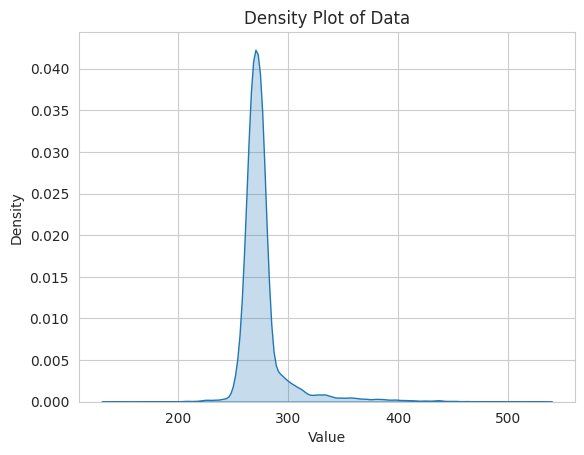

In [15]:
# import seaborn as sns
# sns.boxplot(data=Time)
import seaborn as sns

# 绘制密度图
sns.kdeplot(data['Mid_Price'], shade=True)
plt.xlabel('Value')
plt.ylabel('Density')
plt.title('Density Plot of Data')
plt.show()

In [16]:
from scipy import stats
statistic, pvalue = stats.normaltest(data['level5_Ask_Price'])

# Print the test statistic and p-value
print("Test statistic:", statistic)
print("p-value:", pvalue)

# Interpret the p-value
alpha = 0.05
if pvalue < alpha:
    print("The sample does not come from a normal distribution.")
else:
    print("The sample comes from a normal distribution.")

Test statistic: 36789.82046916123
p-value: 0.0
The sample does not come from a normal distribution.


#### Use Normalization

**Zscore Normalization** (Standard Scaler)

(1) Do the normalization separately

In [17]:
from sklearn.preprocessing import StandardScaler
feature_scaler=StandardScaler()
X_train=feature_scaler.fit_transform(X_train)
X_test=feature_scaler.transform(X_test)

target_scaler=StandardScaler()
y_train=target_scaler.fit_transform(y_train)
y_test=target_scaler.transform(y_test)

(2) Based on the normalized features to calculate the targets

In [18]:
# from sklearn.preprocessing import StandardScaler
# feature_scaler=StandardScaler()
# X_train=feature_scaler.fit_transform(X_train)
# X_test=feature_scaler.transform(X_test)
#
# y_train=(X_train['level1_Ask_Price']+X_train['level1_Bid_Price'])/2
# y_test=(X_test['level1_Bid_Price']+X_test['level1_Ask_Price'])/2

### Reshape the data - Set the time steps

### Set the batch

In [20]:
def reshape_to_batches(a, batch_size):
    #pad if the length is not divisible by the batch_size
    batch_num = np.ceil(a.shape[0] / float(batch_size))
    modulo = batch_num * batch_size - a.shape[0]
    if modulo != 0:
        pad = np.zeros((int(modulo), a.shape[1]))
        a = np.vstack((a, pad))
    return np.array(np.split(a, batch_num))

In [21]:
batch_size = 30 #30 is about 165 minute (5.5min per ts x 30), tried 15 and a few other values too but 30 seems to be the best

X_train_batch = reshape_to_batches(X_train, batch_size)
y_train_batch = reshape_to_batches(y_train, batch_size)
print(X_train_batch.shape, y_train_batch.shape)

X_test_batch = reshape_to_batches(X_test, batch_size)
y_test_batch = reshape_to_batches(y_test, batch_size)
print(X_test_batch.shape, y_test_batch.shape)

(4752, 30, 23) (4752, 30, 1)
(1188, 30, 23) (1188, 30, 1)


#### Set the time steps

In [19]:
# don't count the Mid-price in
def df_to_time_step(df_x,df_y, window_size=30):
  # df_x_np = df_x.to_numpy()
  # df_y_np = df_y.to_numpy()
  X = []
  y = []
  for i in range(len(df_x)-window_size):
    row = [r for r in df_x[i:i+window_size]] # the whole row
    X.append(row)
    label = df_y[i+window_size] # temperature
    y.append(label)
  return np.array(X), np.array(y)

In [25]:
timestep=100
X_train_step, y_train_step=df_to_time_step(X_train, y_train,timestep)
X_test_step, y_test_step= df_to_time_step(X_test,y_test,timestep)
print(X_train_step.shape, y_train_step.shape)
print(X_test_step.shape, y_test_step.shape)

(142448, 100, 23) (142448, 1)
(35538, 100, 23) (35538, 1)


## Create the models

### LSTM_MODEL1

[Time Distributed Layers](https://levelup.gitconnected.com/hands-on-practice-with-time-distributed-layers-using-tensorflow-c776a5d78e7e)

In [22]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam

In [23]:
#Allows the network to accept batches of any size as input when predicting
# Make the model
model1 = Sequential()
lstm=LSTM(32,activation='tanh',recurrent_activation='hard_sigmoid', use_bias=True,
            kernel_initializer='glorot_uniform', recurrent_initializer='orthogonal',
            bias_initializer='zeros', unit_forget_bias=True, kernel_regularizer=None,
            recurrent_regularizer=None, bias_regularizer=None, activity_regularizer=None,
            kernel_constraint=None, recurrent_constraint=None, bias_constraint=None, dropout=0.0,
            recurrent_dropout=0.0, implementation=1, return_sequences=True, return_state=False,
            go_backwards=False, stateful=False, unroll=False, input_shape=(batch_size, 23))
model1.add(lstm)
model1.add(TimeDistributed(Dense(1, activation='linear')))
model1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 30, 32)            7168      
                                                                 


2023-04-28 12:59:32.780349: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:266] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


 time_distributed (TimeDistr  (None, 30, 1)            33        
 ibuted)                                                         
                                                                 
Total params: 7,201
Trainable params: 7,201
Non-trainable params: 0
_________________________________________________________________


In [24]:
# Compile the model
model1.compile(optimizer='rmsprop',
              loss='mean_squared_error',
              metrics=['accuracy'])

In [27]:
model1_fit=model1.fit(X_train_batch, y_train_batch, epochs=500, batch_size=100)

Epoch 1/500
48/48 [==============================] - 1s 22ms/step - loss: 0.0032 - accuracy: 8.4175e-05
Epoch 2/500
48/48 [==============================] - 1s 23ms/step - loss: 0.0029 - accuracy: 8.4175e-05
Epoch 3/500
48/48 [==============================] - 1s 23ms/step - loss: 0.0025 - accuracy: 8.4175e-05
Epoch 4/500
48/48 [==============================] - 1s 23ms/step - loss: 0.0023 - accuracy: 8.4175e-05
Epoch 5/500
48/48 [==============================] - 1s 22ms/step - loss: 0.0022 - accuracy: 8.4175e-05
Epoch 6/500
48/48 [==============================] - 1s 22ms/step - loss: 0.0019 - accuracy: 8.4175e-05
Epoch 7/500
48/48 [==============================] - 1s 22ms/step - loss: 0.0018 - accuracy: 8.4175e-05
Epoch 8/500
48/48 [==============================] - 1s 23ms/step - loss: 0.0018 - accuracy: 8.4175e-05
Epoch 9/500
48/48 [==============================] - 1s 23ms/step - loss: 0.0016 - accuracy: 8.4175e-05
Epoch 10/500
48/48 [==============================] - 1s 22ms/st

In [28]:
# Predict the values
y_pred=model1.predict(X_test_batch)
print(y_pred.shape)

38/38 [==============================] - 0s 4ms/step
(1188, 30, 1)


#### Inverse_Transform and output the mean errors

In [64]:
#linear
from sklearn.metrics import mean_absolute_percentage_error
y_predict=y_pred.flatten()
y_predict_t=y_predict.reshape(-1,1)

y_test_t=y_test_batch.flatten()
y_test_t1=y_test_t.reshape(-1,1)
y_predict_o=target_scaler.inverse_transform(y_predict_t)
y_test_o=target_scaler.inverse_transform(y_test_t1)
y_predict_o=y_predict_o.flatten()
y_test_o=y_test_o.flatten()
print("MAE",mean_absolute_error(y_test_o,y_predict_o))
print("RMSE",np.sqrt(mean_squared_error(y_test_o,y_predict_o)))
print("MAPE",mean_absolute_percentage_error(y_test_o,y_predict_o))
test_results = pd.DataFrame(data={'Test Predictions':y_predict_o, 'Actuals':y_test_o})
test_results

0.2872495742255184
0.2498101951843608
0.0009731745561935682


,Test Predictions,Actuals
0,266.915497,267.000000
1,267.115631,267.000000
2,267.290192,267.000000
3,267.343811,267.000000
4,267.379852,267.000000
...,...,...
35635,266.573639,266.500000
35636,266.082184,266.000000
35637,266.035065,266.000000
35638,276.320282,276.019744


#### Plot the actual values and predictions

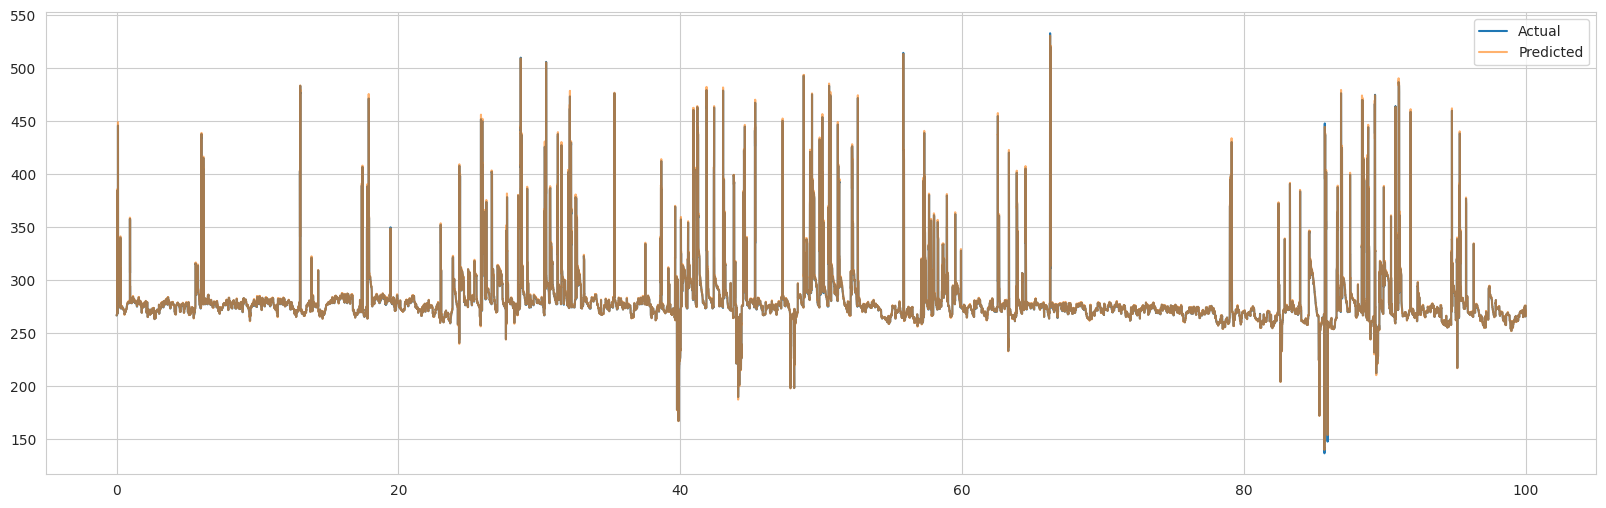

In [65]:
plt.figure(figsize=(20,6))
plt.plot(np.linspace(0, 100, len(y_test_o)), y_test_o, label='Actual')
plt.plot(np.linspace(0, 100, len(y_predict_o)), y_predict_o, alpha=0.6, label='Predicted')
plt.legend()

In [2]:
model1.save('./models/predictions_LSTM_linear')

NameError: name 'model1' is not defined

### LSTM MODEL2

In [66]:
model2 = Sequential()
lstm=LSTM(32,activation='tanh',recurrent_activation='hard_sigmoid', use_bias=True,
            kernel_initializer='glorot_uniform', recurrent_initializer='orthogonal',
            bias_initializer='zeros', unit_forget_bias=True, kernel_regularizer=None,
            recurrent_regularizer=None, bias_regularizer=None, activity_regularizer=None,
            kernel_constraint=None, recurrent_constraint=None, bias_constraint=None, dropout=0.0,
            recurrent_dropout=0.0, implementation=1, return_sequences=True, return_state=False,
            go_backwards=False, stateful=False, unroll=False, input_shape=(batch_size,23))
model2.add(lstm)
# use relu
model2.add(TimeDistributed(Dense(1, activation='relu')))
model2.summary()

model2.compile(optimizer='rmsprop',
              loss='mean_squared_error',
              metrics=['accuracy'])

# Fit the model
model2.fit(X_train_batch, y_train_batch, epochs=500, batch_size=100)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 30, 32)            7168      
                                                                 
 time_distributed_1 (TimeDis  (None, 30, 1)            33        
 tributed)                                                       
                                                                 
Total params: 7,201
Trainable params: 7,201
Non-trainable params: 0
_________________________________________________________________
Epoch 1/500
48/48 [==============================] - 3s 22ms/step - loss: 0.4764 - accuracy: 8.4175e-05
Epoch 2/500
48/48 [==============================] - 1s 22ms/step - loss: 0.2460 - accuracy: 8.4175e-05
Epoch 3/500
48/48 [==============================] - 1s 22ms/step - loss: 0.1878 - accuracy: 8.4175e-05
Epoch 4/500
48/48 [==============================] - 1s 22ms/step - lo

In [67]:
#relu
y_pred = model2.predict(X_test_batch)
print(y_pred.shape)

38/38 [==============================] - 0s 4ms/step
(1188, 30, 1)


In [68]:
from sklearn.metrics import mean_absolute_percentage_error
y_predict=y_pred.flatten()
y_predict_t=y_predict.reshape(-1,1)

y_test_t=y_test_batch.flatten()
y_test_t1=y_test_t.reshape(-1,1)
y_predict_o=target_scaler.inverse_transform(y_predict_t)
y_test_o=target_scaler.inverse_transform(y_test_t1)
y_predict_o=y_predict_o.flatten()
y_test_o=y_test_o.flatten()
print("MAE",mean_absolute_error(y_test_o,y_predict_o))
print("MSE",np.sart(mean_squared_error(y_test_o,y_predict_o)))
print("MAPE",mean_absolute_percentage_error(y_test_o,y_predict_o))
test_results = pd.DataFrame(data={'Test Predictions':y_predict_o, 'Actuals':y_test_o})
test_results

3.9786525386333245
66.49602809418303
0.015463504501798056


,Test Predictions,Actuals
0,276.019745,267.000000
1,276.019745,267.000000
2,276.019745,267.000000
3,276.019745,267.000000
4,276.019745,267.000000
...,...,...
35635,276.019745,266.500000
35636,276.019745,266.000000
35637,276.019745,266.000000
35638,276.019745,276.019744


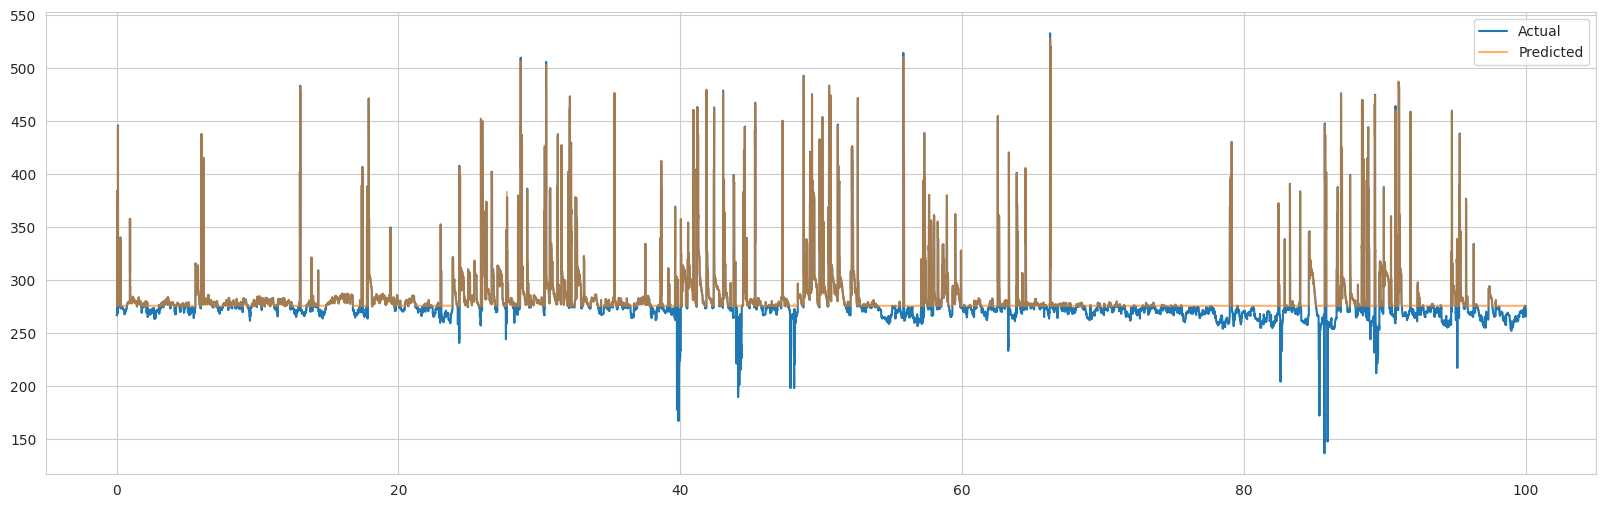

In [69]:
plt.figure(figsize=(20,6))
plt.plot(np.linspace(0, 100, len(y_test_o)), y_test_o, label='Actual')
plt.plot(np.linspace(0, 100, len(y_predict_o)), y_predict_o, alpha=0.6, label='Predicted')
plt.legend()

In [1]:
model2.save('./models/prediction_LSTM_relu')

NameError: name 'model2' is not defined